In [1]:
from tqdm.auto import tqdm
import random
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data_utils
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np
import pathlib
import wandb

In [2]:
wandb.login(key="0f6963d23192cbab4399ad9ec6e7475c7a0d6345")

wandb: Currently logged in as: cs23m024 (cs23m024-gaurav). Use `wandb login --relogin` to force relogin
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /Users/gaurav/.netrc


True

In [3]:
def show_images_and_labels(device, model, test_loader, class_names):
    model.eval()
    with torch.no_grad():  # Disable gradient tracking
        images_per_class = {class_name: 0 for class_name in class_names}
        fig, axes = plt.subplots(10, 3, figsize=(15, 30))  # 10x3 grid
        images_to_log = {}
        total_images_logged = 0
        
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            
            for image, label, pred in zip(images, labels, predicted):
                class_name = class_names[label.item()]
                if images_per_class[class_name] < 3:
                    ax = axes[label.item(), images_per_class[class_name]]
                    img = image.permute(1, 2, 0).cpu().numpy()
                    ax.imshow(img)
                    ax.set_title(f"Predicted: {class_names[pred.item()]}\nOriginal: {class_name}")
                    ax.axis('off')                    
                    images_per_class[class_name] += 1
                    key = f"Img: {total_images_logged}; Pred: {class_names[pred.item()]}; True: {class_name}"
                    images_to_log[key] = wandb.Image(img)     
                    total_images_logged += 1
                    
            if total_images_logged >= 30:
                break
                
        # Prevent overlap
        plt.tight_layout()
        wandb.log(images_to_log)
        plt.show()

In [4]:
def data_generation(dataset_path, num_classes=10, data_augmentation=False, batch_size=32):
    
    # Mean and standard deviation values calculated from function get_mean_and_std

    mean = [0.4708, 0.4596, 0.3891]
    std = [0.1951, 0.1892, 0.1859]


    # Define transformations for training and testing data
    
    augment_transform = transforms.Compose([
        transforms.Resize((256, 256)), 
        transforms.RandomHorizontalFlip(), 
        transforms.RandomRotation(30), 
        transforms.ToTensor(), 
        transforms.Normalize(torch.Tensor(mean), torch.Tensor(std))
    ])

    train_transform = transforms.Compose([
        transforms.Resize((256, 256)),
        transforms.ToTensor(),
        transforms.Normalize(torch.Tensor(mean), torch.Tensor(std))
        ])
    
    test_transform = transforms.Compose([
        transforms.Resize((256, 256)),
        transforms.ToTensor(),
        transforms.Normalize(torch.Tensor(mean), torch.Tensor(std))
    ])


    # Data augmentation (if data_augmentation = True) 

    train_dataset = datasets.ImageFolder(root = dataset_path + "train", transform=train_transform)
    test_dataset = datasets.ImageFolder(root = dataset_path + "val", transform=test_transform)
    
    
    # Split train dataset into train and validation sets

    train_data_class = dict()
    for c in range(num_classes):
        train_data_class[c] = [i for i, label in enumerate(train_dataset.targets) if label == c]

    val_data_indices = []
    val_ratio = 0.2  # 20% for validation
    for class_indices in train_data_class.values():
        num_val = int(len(class_indices) * val_ratio)
        val_data_indices.extend(random.sample(class_indices, num_val))


    # Create training and validation datasets

    train_data = torch.utils.data.Subset(train_dataset, [i for i in range(len(train_dataset)) if i not in val_data_indices])
    val_data = torch.utils.data.Subset(train_dataset, val_data_indices)


    # Create data loaders

    train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_data, batch_size=batch_size, shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    if data_augmentation:
      augmented_dataset = datasets.ImageFolder(root = dataset_path + "train", transform=augment_transform)
      augmented_loader = DataLoader(augmented_dataset, batch_size=batch_size, shuffle=True)
      train_loader = torch.utils.data.ConcatDataset([train_loader.dataset, augmented_loader.dataset])
      train_loader = DataLoader(train_loader, batch_size=batch_size, shuffle=True)


    # Get class names
    classpath = pathlib.Path(dataset_path + "train")
    class_names = sorted([j.name.split('/')[-1] for j in classpath.iterdir() if j.name != ".DS_Store"])

    return train_loader, val_loader, test_loader, class_names

In [7]:
from tqdm.auto import tqdm
import torch
import torch.nn as nn
import torch.optim as optim
import wandb


class ClassCNN(nn.Module):
  def __init__(self, num_filters, activation_function, filter_multiplier, filter_sizes, 
               dropout, batch_norm, dense_size, num_classes, image_size=256):
    super(ClassCNN, self).__init__()
        
    # Defining convolution layers
    layers = []
    params = 0
    self.activation = getattr(nn, activation_function)()
    initial_num_filters = num_filters
    
    for i, filter_size in enumerate(filter_sizes):
        
        if i == 0:
            num_filters = max(num_filters, 1)
            layers.append(nn.Conv2d(in_channels=3, out_channels=initial_num_filters, kernel_size=filter_size))
        
        else:
            num_filters = int(initial_num_filters * (filter_multiplier))     
            num_filters = max(num_filters, 1)   
            layers.append(nn.Conv2d(in_channels=initial_num_filters, out_channels=num_filters, kernel_size=filter_size))
            initial_num_filters = num_filters
            
            
        if batch_norm == True:
            layers.append(nn.BatchNorm2d(num_filters))
            
        layers.append(self.activation)
        layers.append(nn.MaxPool2d(kernel_size=2, stride=2))
    
    self.features = nn.Sequential(*layers)
    
    #Calculate the size of the feature maps after convolution and pooling
    layer_output = image_size
    for filter_size in filter_sizes:
        layer_output = (layer_output - filter_size + 1) // 2
        
    fc1_input_size = num_filters * layer_output * layer_output
    print("fc1_input: ", fc1_input_size)       
    
    # Defining maxpooling layer
    self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
    
    # Defining fully connected layer
    self.flatten = nn.Flatten()
    self.fc1 = nn.Linear(fc1_input_size, dense_size)
    self.dropout = nn.Dropout(dropout)
    self.fc2 = nn.Linear(dense_size, num_classes)
    
  def forward(self, x):
    x = self.features(x)  # Apply convolutional and pooling layers
    x = self.flatten(x)   # Flatten the feature maps into a 1D tensor
    x = self.activation(self.fc1(x))  # Apply activation function to the first fully connected layer
    x = self.dropout(x)   # Apply dropout regularization
    x = self.fc2(x)
    # x = nn.functional.softmax(self.fc2(x), dim=1)  # Apply softmax activation to the output layer
    return x
  

def trainCNN(device, train_loader, val_loader, test_loader, model, num_epochs=10, optimizer="Adam"):    
    criterion = nn.CrossEntropyLoss()
    if optimizer == "Adam":
        opt_func = optim.Adam(model.parameters(), lr=0.001)

    total_correct = 0
    total_samples = 0

    for epoch in tqdm(range(num_epochs)):
        model.train()  # Set the model to training mode
        running_loss = 0.0
        total_correct = 0
        total_samples = 0
        for inputs, labels in tqdm(train_loader):
            inputs, labels = inputs.to(device), labels.to(device)
            opt_func.zero_grad()  # Zero the gradients
            outputs = model(inputs)  # Forward pass
            loss = criterion(outputs, labels)  # Compute the loss
            loss.backward()  # Backward pass
            opt_func.step()  # Update the parameters

            _, predicted = torch.max(outputs, 1)
            total_correct += (predicted == labels).sum().item()
            total_samples += labels.size(0)

            running_loss += loss.item() * inputs.size(0)
        loss = running_loss / len(train_loader.dataset)
        accuracy = total_correct / total_samples
        print(f"Epoch [{epoch+1}/{num_epochs}], Accuracy: {accuracy * 100:.2f}%, Loss: {loss:.4f}")
        wandb.log({'accuracy': accuracy, 'loss': loss})

        # Validation
        model.eval()
        with torch.no_grad():
            val_total_correct = 0
            val_total_samples = 0
            val_running_loss = 0.0
            for val_inputs, val_labels in tqdm(val_loader):
                val_inputs, val_labels = val_inputs.to(device), val_labels.to(device)
                val_outputs = model(val_inputs)
                val_loss = criterion(val_outputs, val_labels)

                _, val_predicted = torch.max(val_outputs, 1)
                val_total_correct += (val_predicted == val_labels).sum().item()
                val_total_samples += val_labels.size(0)

                val_running_loss += val_loss.item() * val_inputs.size(0)

            val_loss = val_running_loss / len(val_loader.dataset)
            val_accuracy = val_total_correct / val_total_samples
            print(f"Epoch [{epoch+1}/{num_epochs}], Validation Accuracy: {val_accuracy * 100:.2f}%, Validation Loss: {val_loss:.4f}")
            wandb.log({'val_accuracy': val_accuracy, 'val_loss': val_loss})
    
        if epoch==num_epochs-1:
            model.eval()
            with torch.no_grad():
                test_total_correct = 0
                test_total_samples = 0
                test_running_loss = 0.0
                for test_inputs, test_labels in tqdm(test_loader):
                    test_inputs, test_labels = test_inputs.to(device), test_labels.to(device)
                    test_outputs = model(test_inputs)
                    test_loss = criterion(test_outputs, test_labels)
    
                    _, test_predicted = torch.max(test_outputs, 1)
                    test_total_correct += (test_predicted == test_labels).sum().item()
                    test_total_samples += test_labels.size(0)
    
                    test_running_loss += test_loss.item() * test_inputs.size(0)
    
                test_loss = test_running_loss / len(test_loader.dataset)
                test_accuracy = test_total_correct / test_total_samples
                print(f"Test Accuracy: {test_accuracy * 100:.2f}%, Test Loss: {test_loss:.4f}")

Train:  563
Val:  63
Test:  63
Device:  mps
filter size:  [5, 5, 5, 5, 5]
fc1_input:  2048


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/563 [00:00<?, ?it/s]

Epoch [1/10], Accuracy: 23.13%, Loss: 2.1130


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch [1/10], Validation Accuracy: 26.81%, Validation Loss: 2.0121


  0%|          | 0/563 [00:00<?, ?it/s]

Epoch [2/10], Accuracy: 30.12%, Loss: 1.9642


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch [2/10], Validation Accuracy: 33.52%, Validation Loss: 1.8666


  0%|          | 0/563 [00:00<?, ?it/s]

Epoch [3/10], Accuracy: 33.43%, Loss: 1.8805


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch [3/10], Validation Accuracy: 35.52%, Validation Loss: 1.8153


  0%|          | 0/563 [00:00<?, ?it/s]

Epoch [4/10], Accuracy: 35.98%, Loss: 1.8115


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch [4/10], Validation Accuracy: 36.87%, Validation Loss: 1.7526


  0%|          | 0/563 [00:00<?, ?it/s]

Epoch [5/10], Accuracy: 38.60%, Loss: 1.7336


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch [5/10], Validation Accuracy: 38.97%, Validation Loss: 1.7344


  0%|          | 0/563 [00:00<?, ?it/s]

Epoch [6/10], Accuracy: 41.30%, Loss: 1.6765


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch [6/10], Validation Accuracy: 41.52%, Validation Loss: 1.6462


  0%|          | 0/563 [00:00<?, ?it/s]

Epoch [7/10], Accuracy: 43.80%, Loss: 1.6034


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch [7/10], Validation Accuracy: 43.17%, Validation Loss: 1.6038


  0%|          | 0/563 [00:00<?, ?it/s]

Epoch [8/10], Accuracy: 46.52%, Loss: 1.5304


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch [8/10], Validation Accuracy: 44.82%, Validation Loss: 1.5445


  0%|          | 0/563 [00:00<?, ?it/s]

Epoch [9/10], Accuracy: 49.02%, Loss: 1.4512


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch [9/10], Validation Accuracy: 47.42%, Validation Loss: 1.4714


  0%|          | 0/563 [00:00<?, ?it/s]

Epoch [10/10], Accuracy: 51.73%, Loss: 1.3813


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch [10/10], Validation Accuracy: 51.18%, Validation Loss: 1.4508


  0%|          | 0/63 [00:00<?, ?it/s]

Test Accuracy: 41.95%, Test Loss: 1.7127


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

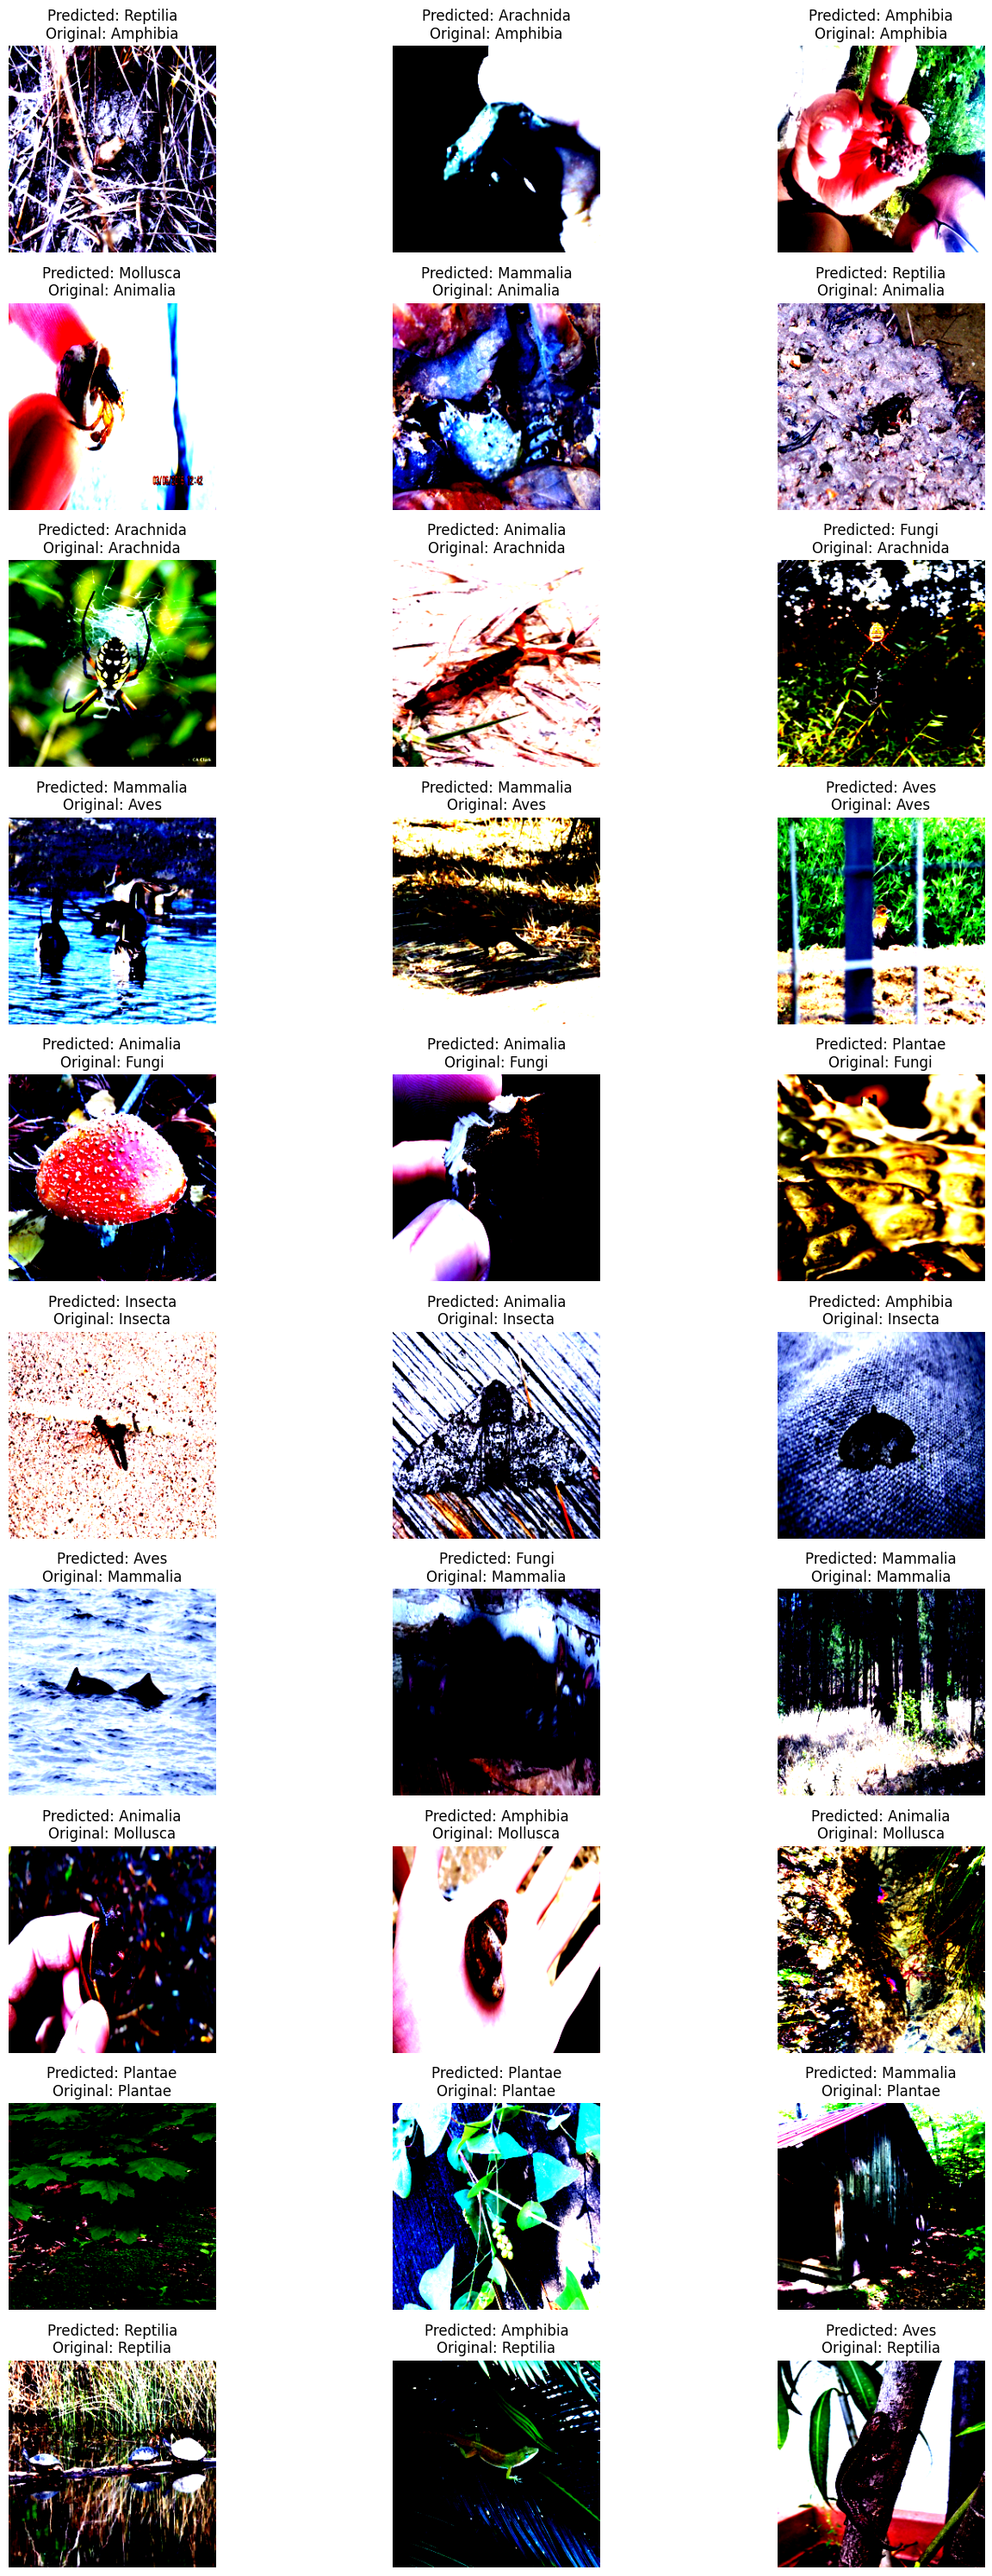

accuracy,▁▃▄▄▅▅▆▇▇█
loss,█▇▆▅▄▄▃▂▂▁
val_accuracy,▁▃▄▄▄▅▆▆▇█
val_loss,█▆▆▅▅▃▃▂▁▁
accuracy,0.51731
loss,1.38133
val_accuracy,0.51176
val_loss,1.45084


In [8]:
def main():
    dataset_path = '../inaturalist_12K/'  

    data_augmentation = True
    batch_size = 32
    batch_norm = True
    dropout = 0.2
    dense_size = 256
    num_filters = 8
    filter_size = 5
    activation_function = 'GELU'
    filter_multiplier = 2

    # sweep_config = {
    #     'method' : 'bayes',                    #('random', 'grid', 'bayes')
    #     'project' : 'Testing_2',
    #     'metric' : {                           # Metric to optimize
    #         'name' : 'accuracy', 
    #         'goal' : 'maximize'
    #     },
    #     'parameters' : {
    #         'data_augmentation': {
    #             'values' : [True]
    #         },
    #         'batch_size': {
    #             'values' : [32]
    #         },
    #         'batch_norm' : {
    #             'values' : [False]
    #         },
    #         'dropout' : {
    #             'values' : [0.2]
    #         },
    #         'dense_size' : {
    #             'values' : [256]
    #         },
    #         'num_filters' : {
    #             'values' : [8]
    #         },
    #         'filter_size' : {
    #             'values' : [5]
    #         },
    #         'activation_function': {
    #             'values' : ['GELU']
    #         },
    #         'filter_multiplier': {
    #             'values' : [2]
    #         }
    #     }
    # }

    def train():
        with wandb.init(project="Testing_2") as run:
            config = wandb.config
            run_name = "aug_" + str(data_augmentation) + "_bs_" + str(batch_size) + "_norm_" + str(batch_norm) + "_dropout_" + str(dropout) + "_fc_" + str(dense_size) + "_nfilters_" + str(num_filters) +"_ac_" + activation_function + "_fmul_" + str(filter_multiplier)
            wandb.run.name = run_name
            
            train_loader, val_loader, test_loader, class_names = data_generation(dataset_path, 
                                                                             num_classes=10, 
                                                                             data_augmentation=data_augmentation, 
                                                                             batch_size=batch_size)
        
            print("Train: ", len(train_loader))
            print("Val: ", len(val_loader))
            print("Test: ", len(test_loader))
            
            # for images, labels in train_loader:
            #     show_images(class_names, images, labels)
            #     break
            
            filter_sizes = []
            for i in range(5):
                filter_sizes.append(filter_size)
            
            device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
            print("Device: ", device)
            
            print("filter size: ", filter_sizes)
            model = ClassCNN(num_filters=num_filters, 
                                activation_function=activation_function, 
                                filter_multiplier=filter_multiplier,
                                filter_sizes=filter_sizes, 
                                dropout=dropout, 
                                batch_norm=batch_norm,
                                dense_size=dense_size, 
                                num_classes=10, 
                                image_size=256)
            model.to(device)
            
            trainCNN(device, train_loader, val_loader, test_loader, model, num_epochs=10, optimizer="Adam")
            
            show_images_and_labels(device, model, test_loader, class_names)

    # sweep_id = wandb.sweep(sweep=sweep_config)
    # wandb.agent(sweep_id, function=train, count=1)
    train()
    wandb.finish()

main()